# Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

The notebook includes A/B testing for an e-commerce website. The goal is to help a company understand if they should implement a new page in order to improve users' conversion rate to maximize revenue.

<a id='probability'></a>
#### Part I - Probability

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

`1.` a. Read in the dataset and take a look at the top few rows:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.query('converted == 1').user_id.nunique() / df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
len(df.query('group == "control" & landing_page == "new_page"')) + len(df.query('group == "treatment" & landing_page == "old_page"'))

3893

f. Check for missing values

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No rows have missing values.

`2.` For the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if this row truly received the new or old page.

a. Drop rows that are not matched and store new dataframe in **df2**.

In [8]:
df2 = df.drop(df.query('group == "control" & landing_page == "new_page"').index)

In [9]:
df2 = df2.drop(df.query('group == "treatment" & landing_page == "old_page"').index)

Double check if all individuals in `treatment` received the `new_page` as the `landing_page`. This should output 0

In [10]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. Check for duplicated `user_id`.

In [12]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. Remove one of the rows with a duplicate `user_id`.

In [13]:
df2.drop(2893, inplace=True)

confirm the drop. Should return True.

In [14]:
df2.shape[0] == df2.user_id.nunique()

True

`4.` a. Probability of an individual converting regardless of the page they receive.

In [15]:
df2.converted.mean()

0.11959708724499628

b. Probability of an individual converting, given that he/she was in the `control` group.

In [16]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Probability of an individual converting, given that he/she was in the `treatment` group.

In [17]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. Probability of an individual receiving the `new_page`.

In [18]:
len(df2.query('landing_page == "new_page"')) / df2.shape[0]

0.5000619442226688

**Based on the results above, there isn't sufficient evidence to conclude that the `new_treatment` page leads to more conversions**

<a id='ab_test'></a>
### Part II - A/B Test

`1.` Null and alternative hypotheses assuming that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.

$$H_0: p_{old} \geq p_{new} $$


$$H_1: p_{old} < p_{new}  $$

`2.` For this part, I assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, I assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

a. The **conversion rate** for $p_{new}$ under the null.

In [19]:
p_new = (df2.converted == 1).mean()
p_new

0.11959708724499628

b. The **conversion rate** for $p_{old}$ under the null.

In [20]:
p_old = (df2.converted == 1).mean()
p_old

0.11959708724499628

c. The number of individuals $n_{new}$ in the treatment group.

In [21]:
n_new = len(df2.query('landing_page == "new_page"'))
n_new

145310

d. The number of individualsis $n_{old}$ in the control group.

In [22]:
n_old = len(df2.query('landing_page == "old_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.

In [23]:
new_page_converted = np.random.binomial(n_new, p_new)
new_page_converted

17321

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.

In [24]:
old_page_converted = np.random.binomial(n_old, p_old)
old_page_converted

17398

g. Find $p_{new}$ - $p_{old}$ for the simulated values from parts (e) and (f).

In [25]:
(new_page_converted / n_new) - (old_page_converted / n_old)

-0.000559571650066884

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    p_diffs.append((new_page_converted / n_new) - (old_page_converted / n_old))
    
p_diffs = np.array(p_diffs)

In [27]:
p_diffs.mean()

4.3593827909305936e-07

i. Plot a histogram of the **p_diffs**.

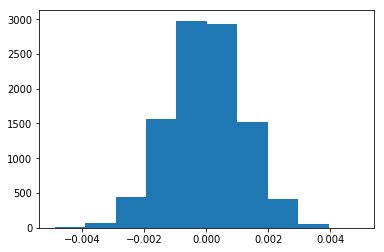

In [28]:
plt.hist(p_diffs);

The histogram shows that most **p_diffs** are close to **0**.

j. Observed difference in coversion rates in `treatment` and `control` groups.

In [29]:
obs_diff = (df2.query('group == "treatment"').converted.mean()) - (df2.query('group == "control"').converted.mean())
obs_diff

-0.0015782389853555567

Proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**: `p-value`.

In [30]:
(p_diffs > obs_diff).mean()

0.9067

k. The **p-value (0.90) is > 0.05**. With this high p-value we can **accept the null hypothesis** which states that the old version of the website is better or as good as the new version.

$$H_0: p_{old} \geq p_{new} $$

l. To confirm the results, I'm going to perform a ztest from the **statsmodels** library. Below values show the number of conversions for each page, as well as the number of individuals who received each page.

In [31]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"').converted.sum()
convert_new = df2.query('landing_page == "new_page"').converted.sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Perform `stats.proportions_ztest` to compute the test statistic and p-value.

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [33]:
from scipy.stats import norm

norm.ppf(1-(0.05/2)) # Tells us what our critical value at 95% confidence is

1.959963984540054

n. The **p-value is 0.905** and **z-score is 1.31**. If p-value is greater than 0.05 and z-score is smaller than 1.96, we can **accept the null hypothesis**. **It agrees** with the findings in parts j and k.

<a id='regression'></a>
### Part III - Logistic regression approach

`1.` a. The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives. However, I first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received. I will add **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2['intercept'] = 1
df2[['not_ab_page','ab_page']] = pd.get_dummies(df['group'])
df2 = df2.drop('not_ab_page',axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


b. Use **statsmodels** to instantiate the regression model on the two columns I created in part b., then fit the model using the same columns to predict whether or not an individual converts. Next, provide the summary of the model.

In [35]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 12 Feb 2019   Pseudo R-squ.:               8.077e-06
Time:                        09:46:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

Convert the p-value from a two-tailed test to a one-tailed test to check if it matches what we got in the previous part.

In [47]:
1-(0.190/2)

0.905

c. The p-value associated with **ab_page** is **0.190**. It is still **> 0.05** which implies that the results are **not statistically significant**. There results differ from **Part II** because proviously we used a one-tailed test, while regression uses a two-tailed test. To confirm it, I checked if **1-(0.190/2)** equals to the p-value from **Part II**. These values are the same.

d. It is worth considering other factors to add into the regression model because they can provide **new insights** into what influences the conversion rate (e.g. people from different countries or people who test at certain time of the day respond differently to treatment. Problems associated with this approach are:
1. **Collinearity**: it can occur when some of the independent variables are correlated. It tends to inflate the variance of at least one estimated regression coefficient ('Wikipedia').
2. **Multiple comparisons problem**: It occurs when one considers a set of statistical inferences simultaneously or infers a subset of parameters selected based on the observed values.The more inferences are made, the more likely erroneous inferences are to occur '('Wikipedia'). One way to prevent it from happening is to use **Bonferroni correction**.

e. Now along with testing if the conversion rate changes for different pages, I will also add an effect based on which country a user lives in.

Load the countries data.

In [37]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


Join two dataframes

In [38]:
df2 = df2.join(countries.set_index('user_id'), on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


Check what countries are in the dataframe

In [39]:
df2.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

Create dummie variables

In [40]:
df2[['CA','UK','US']] = pd.get_dummies(df2['country'])
df2 = df2.drop('US', axis=1) # US is a baseline category
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0


Instantiate the regression model, fit the model and provide the summary for the Canadian users.

In [41]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept','CA']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 12 Feb 2019   Pseudo R-squ.:               1.259e-05
Time:                        09:46:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1016
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9941      0.006   -340.272      0.000      -2.006      -1.983
CA            -0.0434      0.027     -1.629      0.103      -0.096       0.009
==============================================================================
"""

Exponentiate the coef to interpret the results

In [49]:
np.exp(-0.0434)

0.9575283021336983

Users from **CA** are **0.958** times as likely as users from the **US** to convert (if other variables remain constant). However, the results are **not statistically significant** as **p-value > 0.05**.

Instantiate the regression model, fit the model and provide the summary for the UK users.

In [43]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366120
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 12 Feb 2019   Pseudo R-squ.:               4.280e-06
Time:                        09:46:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3399
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9994      0.007   -302.640      0.000      -2.012      -1.986
UK             0.0126      0.013      0.955      0.340      -0.013       0.038
==============================================================================
"""

Exponentiate the coef to interpret the results

In [50]:
np.exp(0.0126)

1.0126797144488495

Users from the **UK** are **1.013** times as likely as users from the **US** to convert (if other variables remain constant). However, the results are **not statistically significant** as **p-value > 0.05**.

f. Though I have now looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [45]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Feb 2019   Pseudo R-squ.:               2.323e-05
Time:                        09:46:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

Exponentiate the coef to interpret the results

In [51]:
np.exp(-0.0149), np.exp(-0.0408), np.exp(0.0099)

(0.9852104557227469, 0.9600211149716509, 1.0099491671175422)

While fitting all variables into one model, the conversion rates **slightly changed** from the previous point; however, the results are still **not statistically significant** (**p-value > 0.05**).

### Conclusion

The results imply the that company **should not launch the new website** as there is **not enough evidence** to conlude that it affects the users' conversion rate.